## The Vanishing/Exploding Gradients Problems

* The backpropagation algorithm’s second phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step.
* Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem.
* In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces most often in recurrent neural networks.
* More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

* It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio.
  * The authors found a few suspects, including the combination of the popular sigmoid (logistic) activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1)
  * In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. 
  * Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the sigmoid function has a mean of 0.5 not 0

### Sigmoid

Looking at the sigmoid activation function, 
*   you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0 (i.e., the curve is flat at both extremes). 
*   Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

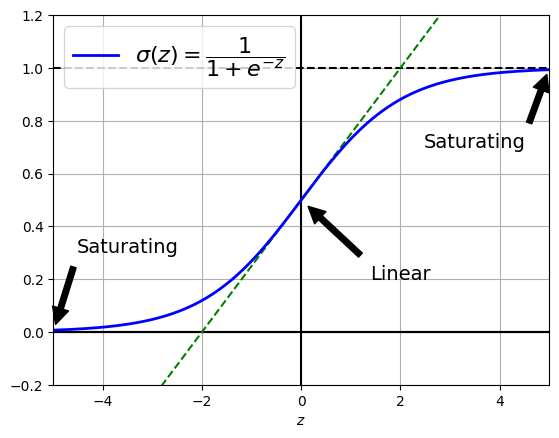

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2, label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")

plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

### Glorot and He Initialization 

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. 
*   For the signal to flow properly, 
    *   We need the variance of the outputs of each layer to be equal to the variance of its inputs
    *   We need the gradients to have equal variance before and after flowing through a layer in the reverse direction
* It is actually not possible to guarantee both above requirements unless the layer has an equal number of inputs and outputs (these numbers are called the fan-in and fan-out of the layer)
* But Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described below.

#### Xavier initialization or Glorot initialization

Normal distribution with mean 0 and variance $\sigma^2 = \dfrac{1}{fan}_{avg}$

Or a uniform distribution between $−r$ and $+r$, with $r = \sqrt{{\dfrac{3}{fan}_{avg}}}$

where, ${fan}_{avg} = \dfrac{{fan}_{in} + {fan}_{out}}{2}$

#### LeCun initialization

* If you replace ${fan}_{avg}$ with ${fan}_{in}$ in the above equation you get a LeCun initialization
* LeCun initialization is equivalent to Glorot initialization when ${fan}_{in} = {fan}_{out}$

### Initialization strategy

| Initialization    | Activation functions             | $\sigma^2$ (Normal)    |
| :---------------- | :------:                         | ----:                  |
| Glorot            |   None, tanh, sigmoid, softmax   | $\dfrac{1}{fan}_{avg}$ |
| He                |   ReLU, Leaky ReLU, ELU, GELU, Swish, Mish| $\dfrac{2}{fan}_{in}$  |
| LeCun             |  SELU                            | $\dfrac{1}{fan}_{in}$  |


* *By default, Keras uses Glorot initialization with a uniform distribution* 
* When you create a layer, you can switch to He initialization by setting kernel_initializer= "he_uniform" or kernel_initializer="he_normal" like this:

In [11]:
import tensorflow as tf
dense = tf.keras.layers.Dense(50, activation="relu",
kernel_initializer="he_normal")

Alternatively, you can obtain any of the other initializations and more
using the VarianceScaling initializer. For example, if you want He initialization

In [12]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                        distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                                  kernel_initializer=he_avg_init)

## Better Activation Functions

### ReLU

* Advantages,
  * ReLU activation function does not saturate for positive values
  * it is very fast to compute
* Disadvantages,
  * It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die”, meaning they stop outputting anything other than 0. 
  * In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate.
  * A neuron dies when its weights get tweaked in such a way that the input of the ReLU function (i.e., the weighted sum of the neuron’s inputs plus its bias term) is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative

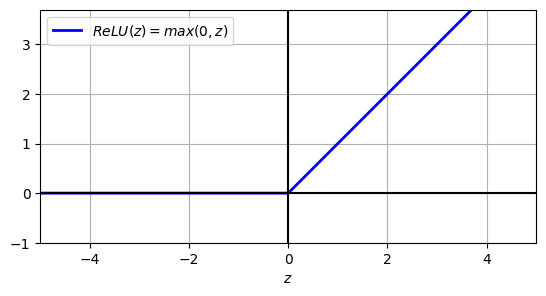

In [15]:
def relu(z):
    return np.maximum(0, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, relu(z), "b-", linewidth=2, label=r"$ReLU(z) = max(0, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

### Leaky ReLU

Leaky ReLU intends to solve the problems associated with ReLU. 
* The leaky ReLU activation function is defined as $LeakyReLUα(z)$ = $max(αz, z)$. 
* The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0. 
* Having a slope for z < 0 ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. 

* A 2015 paper by Bing Xu et al. compared several variants of the ReLU activation function, 
  * One of its conclusions was that the leaky variants always outperformed the strict ReLU activation function.
  * In fact, setting $\alpha$ = 0.2 (a huge leak) seemed to result in better performance than $\alpha$ = 0.01 (a small leak). 
  * The paper also evaluated the randomized leaky ReLU (RReLU), where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. 
  * Finally, the paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be learned during training: instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter. 
  * PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set

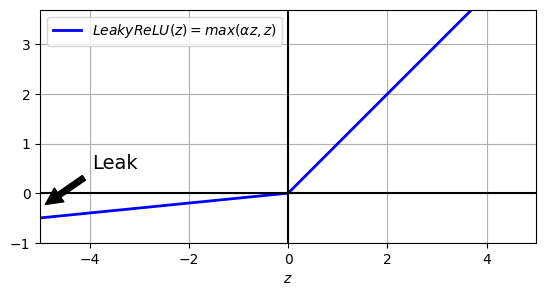

In [16]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [17]:
# Keras
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) # defaults to alpha=0.3 dense = tf.keras.layers.Dense(50, activation=leaky_relu,
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

*ReLU, leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions: their derivatives abruptly change (at z = 0). This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence.* 

*So now we will look at some smooth variants of the ReLU activation function, starting with ELU and SELU*